<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/optimal_policy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Setup**

In [ ]:
%%capture 
!pip install jaxopt

In [ ]:
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
import jaxopt
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial 

In [ ]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### **Heterogeneity**

In [ ]:
def sample_params(key):
  subkey1, subkey2, subkey3 = jax.random.split(key, 3)
  scale = jax.random.uniform(subkey1, minval=1., maxval=10.)
  alpha = jax.random.uniform(subkey2, minval=0.3, maxval=0.7)
  m = jax.random.uniform(key, minval=12., maxval=20.)
  return scale, alpha, m

### **Economic Functions**

In [ ]:
def utility_fn(scale, alpha, x1, x2): 
  return scale *x1**alpha * x2 **(1-alpha)

def budget_constraint(m, p1, p2, x1):
  return m/p2 - p1/p2*x1

def expenditure_fn(p1, p2, x1, x2):
  return p1*x1 + p2*x2

### **Individual-Level Solver Related Functions**

In [ ]:
def System_Consumer(utility_fn, expenditure_fn, income, params):
  h, c, l = params
  
  a1, a2 = jax.grad(utility_fn, argnums=(0, 1))(h, c)
  b1, b2 = jax.grad(expenditure_fn, argnums=(0, 1))(h, c)

  return jnp.array([a1 - l*b1, a2-l*b2, income - expenditure_fn(h,c)])

def Solver_Consumer(f_root):

  g = lambda z: z - jnp.linalg.solve(jax.jacobian(f_root)(z), f_root(z))

  def body_fn(val):
    next_guess = g(val)
    return next_guess 

  def cond_fn(val):
    return jnp.linalg.norm(f_root(val)) > 1e-3

  z = jax.lax.while_loop(cond_fn, body_fn, init_val=jnp.ones(3))
  return z 

def optimal_bundle(idv_params, p1, p2):
  scale, alpha, income = idv_params 
  partial_utility_fn = partial(utility_fn, scale, alpha)
  partial_expenditure_fn = partial(expenditure_fn, p1, p2)
  f_root = partial(System_Consumer, partial_utility_fn, partial_expenditure_fn, income)
  opt_bundle = Solver_Consumer(f_root)
  return opt_bundle[0], opt_bundle[1]

### **Market Demand & Supply**

In [ ]:
p2 = 12.

@jax.jit
def Demand(p):
  keys = jax.random.split(jax.random.PRNGKey(0), 1000)
  indv_params = jax.vmap(sample_params)(keys)
  individual_demand = jax.vmap(partial(optimal_bundle, p1=p, p2=p2))(indv_params)[0]
  return jnp.sum(individual_demand)

def Supply(p):
  return 250*p 

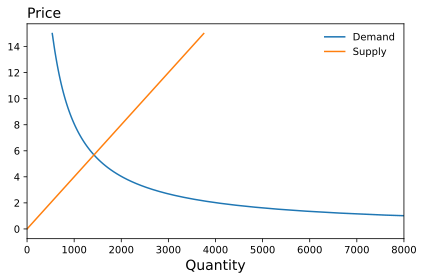

In [ ]:
#@title **Graph the Market** { display-mode: "form" }
fig = plt.figure(dpi=300, tight_layout=True)
ps = jnp.linspace(0, 15, 100)
ds = jax.vmap(Demand)(ps)
ss = jax.vmap(Supply)(ps)
plt.plot(ds, ps, label='Demand') 
plt.plot(ss, ps, label='Supply')
plt.legend(frameon=False)
plt.xlim(0, 8000)
plt.title('Price', loc='left', size=14)
plt.xlabel('Quantity', size=14)
fig.savefig('eq1.png', format='png')
plt.show()

### **Market-Level Solver Related Functions**

In [ ]:
def System_Market(tax, x):
  qd, qs, pd, ps = x 
  return jnp.array([qd - Demand(pd), qs - Supply(ps), qd-qs, pd-tax-ps])
  
def Market_Solver(f_root):

  g = lambda z: z - jnp.linalg.solve(jax.jacfwd(f_root)(z), f_root(z))

  def body_fn(val):
    next_guess = g(val)
    return next_guess 
  def cond_fn(val):
    return jnp.linalg.norm(f_root(val)) > 1e-3

  z = jax.lax.while_loop(cond_fn, body_fn, init_val=jnp.ones(4))
  return z

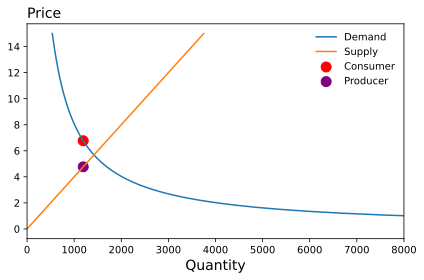

In [ ]:
#@title **Graph the Market** { display-mode: "form" }
tax = 2.0
qd_opt, qs_opt, pd_opt, ps_opt = Market_Solver(partial(System_Market, tax))

fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(ds, ps, label='Demand') 
plt.plot(ss, ps, label='Supply')
plt.scatter(qd_opt, pd_opt, s=100, color='red', label='Consumer')
plt.scatter(qs_opt, ps_opt, s=100, color='purple', label='Producer')
plt.legend(frameon=False)
plt.xlim(0, 8000)
plt.title('Price', loc='left', size=14)
plt.xlabel('Quantity', size=14)
fig.savefig('eq2.png', format='png')
plt.show()

### **Optimal Policy**

In [ ]:
@jax.jit 
def gov_obj(tax):
  return Market_Solver(partial(System_Market, tax))[0]*tax - 1000*tax

In [ ]:
jax.jacfwd(gov_obj)(2.)

DeviceArray(-14.50978963, dtype=float64)

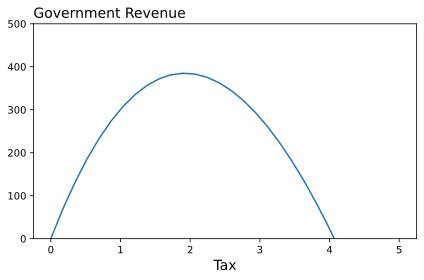

In [ ]:
ts = jnp.linspace(0., 5., 30)
qs = jax.vmap(gov_obj)(ts)

fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(ts, qs)
plt.ylim(0, 500)
plt.title('Government Revenue', loc='left', size=14)
plt.xlabel('Tax', size=14)
fig.savefig('eq4.png', format='png')
plt.show()

In [ ]:
guess = jnp.ones(shape=())*0.0
lr = 0.001
guesses = [guess]
for i in range(100):
  guess = guess + lr*jax.jacfwd(gov_obj)(guess)
  guesses.append(guess)

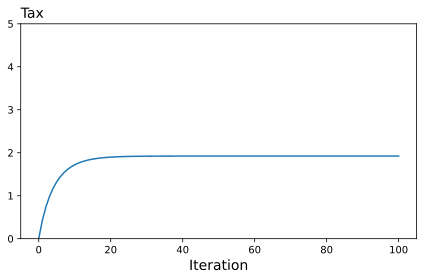

In [ ]:
fig = plt.figure(dpi=300, tight_layout=True)
plt.plot(jnp.arange(101), guesses)
plt.ylim(0, 5.)
plt.title('Tax', loc='left', size=14)
plt.xlabel('Iteration', size=14)
fig.savefig('tsp.png', format='png')
plt.show()

In [ ]:
gov_obj(5.8)

DeviceArray(23.12270781, dtype=float64)

In [ ]:
gov_obj(5.753068875804419)

DeviceArray(23.1241364, dtype=float64)